### Explore the summary stats by plotting the histogram

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import pickle
import os

In [65]:
def gather_hay_objectives():
    filedir = '/home/michael/Documents/arco_sims/small_prior/91_around_ground_truth_005_CMmHWT_'
    files = os.listdir(filedir)

    filenames = []
    for file in files:
        if file[-6:] != 'pickle':
            filenames.append(file)
            
    k = 0
    all_theta = []
    all_x = []
    for f in filenames:
        with open(filedir+'/'+f, 'rb') as handle:
            b = pickle.load(handle, encoding='latin1')
            for simulation in b:
                theta = simulation[0]
                x_dict = simulation[2]
                x = []
                for key in x_dict.keys():
                    x.append(x_dict[key])
                all_theta.append(theta)
                all_x.append(x)
    all_theta = np.asarray(all_theta)
    all_x = np.asarray(all_x)
    print("all", all_theta.shape)
    print("allx", all_x.shape)
    return all_theta, all_x

In [67]:
all_theta, all_x = gather_hay_objectives()

all (2000000, 35)
allx (2000000, 11)


FileNotFoundError: [Errno 2] No such file or directory: '../../../arco_sims/small_prior/hay_objecties/hay.npz'

In [69]:
np.savez('../../../arco_sims/small_prior/hay_objectives/hay.npz', params=all_theta, data=all_x)

In [70]:
data = np.load('../../../arco_sims/small_prior/hay_objectives/hay.npz', allow_pickle=True)

x = torch.as_tensor(data['data'], dtype=torch.float32)
theta_not_standardized = torch.as_tensor(data['params'], dtype=torch.float32)

In [74]:
x = x

In [72]:
x_not_standardized = deepcopy(x)

In [73]:
x_mean = x.mean(dim=0)
x_std = x.std(dim=0)

x = (x-x_mean) / x_std
x = x.numpy()

### Load x_o

In [79]:
import pickle
#with open('../results/observation/x_o_new_ss.pickle', 'rb') as handle:
#    x_o = pickle.load(handle)
    
#x_o = torch.as_tensor(x_o)

x_o = torch.as_tensor(np.load('../results/observation/x_o_hay.npz')['x_o'], dtype=torch.float32)
x_o = x_o
print('x', x_o)
x_o = (x_o - x_mean) / x_std
x_o = x_o.unsqueeze(0)
x_o = x_o.numpy()

x tensor([0.6275, 1.0714, 0.0000, 1.8408, 0.1828, 1.5292, 0.0182, 0.6768, 2.0597,
        0.0000, 0.5047])


In [80]:
x_o

array([[-0.5644421 , -1.3512897 , -1.3530166 , -1.3483759 , -0.50686634,
        -0.5728331 , -1.3571174 , -0.50316   , -0.5260901 , -1.2379471 ,
        -1.3531005 ]], dtype=float32)

Minimum:   -0.57153785
Maximum:   2.2210302


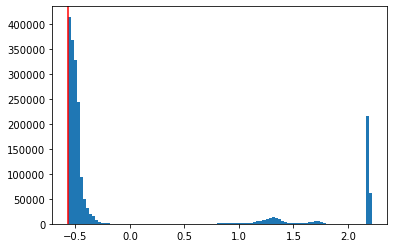

Minimum:   -1.3542073
Maximum:   0.7354568


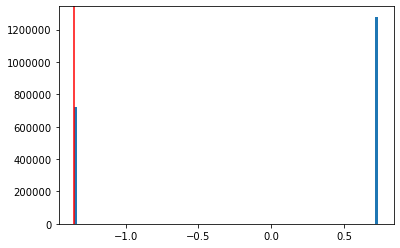

Minimum:   -1.3530166
Maximum:   0.73228216


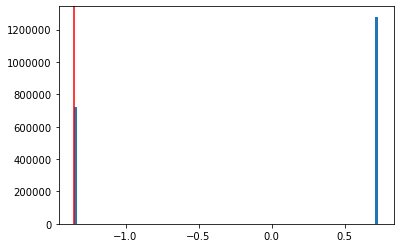

Minimum:   -1.349288
Maximum:   0.73716533


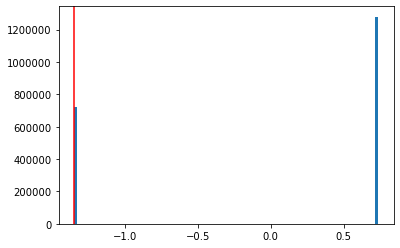

Minimum:   -0.5088855
Maximum:   2.2193272


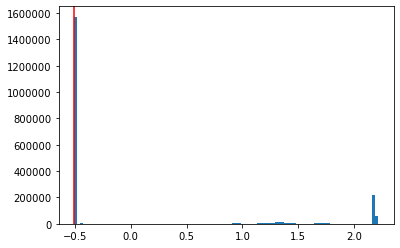

Minimum:   -0.5902414
Maximum:   2.2208004


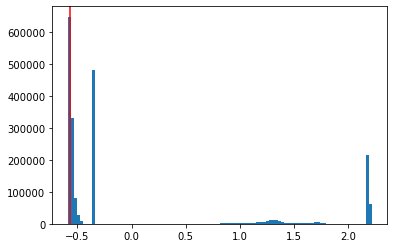

Minimum:   -1.3572701
Maximum:   0.73418885


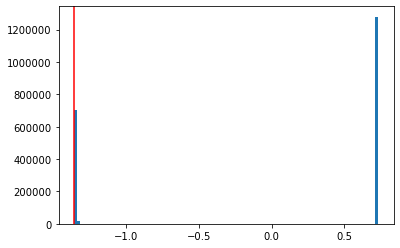

In [81]:
for i in range(7):
    print("Minimum:  ", np.min(x[:, i]))
    print("Maximum:  ", np.max(x[:, i]))
    plt.hist(x[:, i], bins=100)
    plt.axvline(x_o[0, i], color='r')
    plt.show()

## Use this to clean up the data
If a sample is larger than 10 standard deviations away from the mean -> discard it because it might break training.

In [59]:
no_value_too_large = np.all(x < 5.0, axis=1)

In [60]:
x_clear = x_not_standardized[no_value_too_large].numpy()
x_clear_standardized = x[no_value_too_large]
theta_clear = theta_not_standardized[no_value_too_large].numpy()

In [61]:
x_clear.shape

(1984680, 5)

In [62]:
no_value_too_small = np.all(x_clear_standardized > -5.0, axis=1)
x_fully_clear = x_clear[no_value_too_small]
theta_fully_clear = theta_clear[no_value_too_small]

In [63]:
x_fully_clear.shape

(1984680, 5)

In [66]:
at_least_one_spike = x_fully_clear[:,0]>0.0
x_calibrated = x_fully_clear[at_least_one_spike]
theta_calibrated = theta_fully_clear[at_least_one_spike]

In [72]:
x_calibrated.shape

(728700, 5)

In [67]:
np.savez('../results/cleaned_up_data_onlyNumSpikes_calibrationKernel.npz', data=x_calibrated, params=theta_calibrated)

### Repeat the whole analysis with the cleaned up dataset just to be sure everything worked

In [68]:
data = np.load('../results/cleaned_up_data_onlyNumSpikes_calibrationKernel.npz', allow_pickle=True)

x = torch.as_tensor(data['data'], dtype=torch.float32)
theta_not_standardized = torch.as_tensor(data['params'], dtype=torch.float32)

In [69]:
x_mean = x.mean(dim=0)
x_std = x.std(dim=0)

x = (x-x_mean) / x_std
x = x.numpy()

In [70]:
x_o = torch.as_tensor(np.load('../results/observation/x_o_new_ss.npz')['x_o'], dtype=torch.float32)
x_o = x_o[::7]

x_o = (x_o - x_mean) / x_std
x_o = x_o.unsqueeze(0)
x_o = x_o.numpy()

Minimum:   -0.42032123
Maximum:   7.7291074


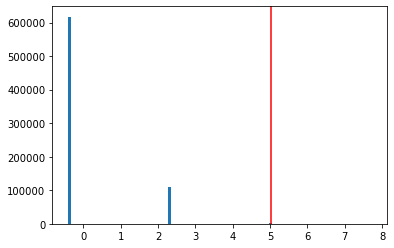

Minimum:   -1.2803866
Maximum:   3.938874


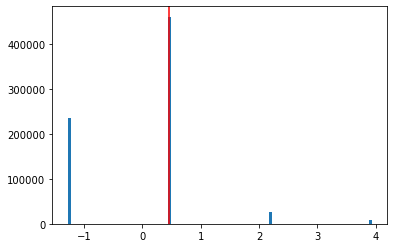

Minimum:   -16.641474
Maximum:   66.691345


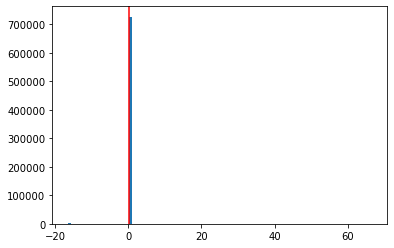

Minimum:   -0.98989505
Maximum:   2.998971


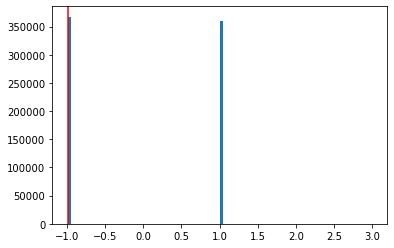

Minimum:   -0.52600574
Maximum:   10.435782


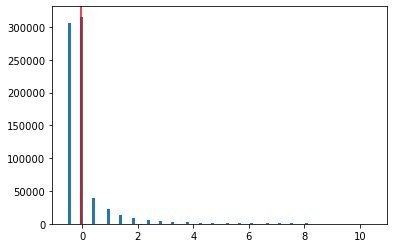

In [71]:
for i in range(5):
    print("Minimum:  ", np.min(x[:, i]))
    print("Maximum:  ", np.max(x[:, i]))
    plt.hist(x[:, i], bins=100)
    plt.axvline(x_o[0, i], color='r')
    plt.show()